In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.core.display import HTML

In [179]:
bn = gum.loadBN("Stress Test 8.dsl")

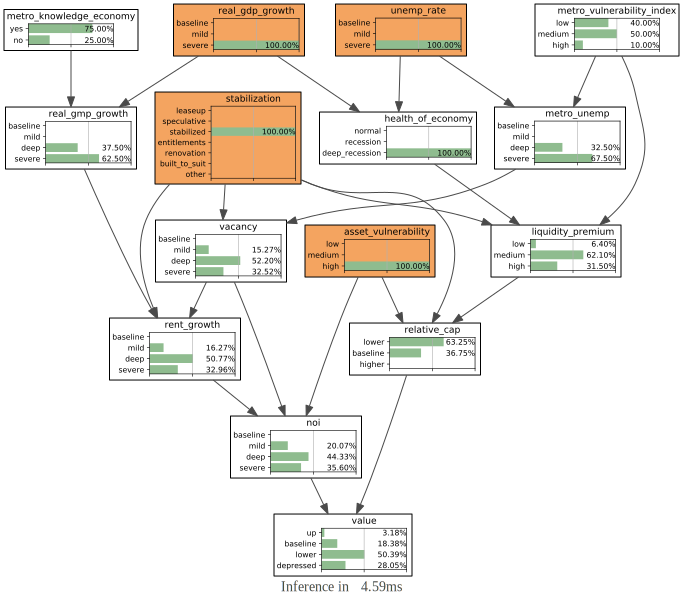

In [180]:
gnb.showInference(bn, evs={"stabilization":"stabilized", "real_gdp_growth":"severe", "unemp_rate":"severe", "asset_vulnerability":"high"}, size="20")

In [4]:
#bn.cpt("value")

In [5]:
#bn.cpt("rent_growth")

In [6]:
#bn.cpt("vacancy")

In [110]:
gum.getPosterior(bn,{"stabilization":"stabilized","real_gdp_growth":"severe", "unemp_rate":"severe", "asset_vulnerability":"low"},'value').tolist()

[0.04413679197291172,
 0.23398968370797038,
 0.5254728954480561,
 0.1964006288710618]

In [10]:
## Start analysis using BN as a function to determine value changes for each asset for quarters ahead

import pandas as pd
import numpy as np

from scipy.stats import norm,maxwell
from scipy.stats import beta

In [11]:
import altair as alt
from altair.expr import datum

#t = lambda data: pipe(data, limit_rows(max_rows=10000), to_values)
#alt.data_transformers.register('custom', t)
#alt.data_transformers.enable('custom')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
import matplotlib as mpl

In [196]:
pm = pd.read_excel('master_properties.xlsx', sheet_name="Master-New")

pm = pm[(pm['Active/Sold'] == 'Active')].copy()

pm = pm[['Property Name', 'Property Type', 'MSA', 'Address', 'City', 'State', 'Stabilization', 'Risk Rating',
                 'Knowledge Economy', 'Metro Risk Index', 'Asset Risk Index',
                'MV Assets', 'MV Liabilities', 'MV']].reset_index(drop=True)



In [198]:
# Initialise data to lists.  
data = [{'Scenario': 'U Shaped', 'Quarter': '2020-03-31', 'GDP': '-0.048', 'UE': '0.044'}, 
        {'Scenario': 'U Shaped', 'Quarter': '2020-06-30', 'GDP': '-0.445', 'UE': '0.14'}, 
        {'Scenario': 'U Shaped', 'Quarter': '2020-09-30', 'GDP': '0.244', 'UE': '0.16'}, 
        {'Scenario': 'U Shaped', 'Quarter': '2020-12-31', 'GDP': '0.189', 'UE': '0.117'}]  
    
# Creates DataFrame.  
df_scenarios = pd.DataFrame(data, columns=['Scenario', 'Quarter', 'GDP', 'UE'])  
#df_scenarios.set_index('Quarter', inplace=True)    
# Print the data  
df_scenarios  

,Scenario,Quarter,GDP,UE
0,U Shaped,2020-03-31,-0.048,0.044
1,U Shaped,2020-06-30,-0.445,0.14
2,U Shaped,2020-09-30,0.244,0.16
3,U Shaped,2020-12-31,0.189,0.117


In [199]:
capital_growth = {
                    '2020-03-31': {
                            'office': [-0.0748,-0.1,-0.12205,-0.1231],
                            'retail': [-0.1212,-0.15,-0.1752,-0.1764],
                            'residential': [-0.056,-0.08,-0.101,-0.102],
                            'mixed-use': [-0.056,-0.08,-0.101,-0.102],
                            'self storage': [-0.036,-0.06,-0.081,-0.082],
                            'senior housing': [-0.056,-0.08,-0.101,-0.102],
                            'industrial': [-0.026,-0.05,-0.071,-0.072],
                            'mob': [-0.0736,-0.1,-0.1231,-0.1242],
                            'retail/office': [-0.1236,-0.15,-0.1731,-0.1742],
                            'student housing': [-0.096,-0.12,-0.141,-0.142],
                            'hotel': [-0.1212,-0.15,-0.1752,-0.1764],
                            'land': [-0.0736,-0.1,-0.1231,-0.1242]},
                   '2020-06-30': {
                            'office': [-0.1122,-0.15,-0.183075,-0.1878],
                            'retail': [-0.1818,-0.225,-0.2628,-0.2682],
                            'residential': [-0.084,-0.12,-0.1515,-0.156],
                            'mixed-use': [-0.084,-0.12,-0.1515,-0.156],
                            'self storage': [-0.054,-0.09,-0.1215,-0.126],
                            'senior housing': [-0.084,-0.12,-0.1515,-0.156],
                            'industrial': [-0.039,-0.075,-0.1065,-0.111],
                            'mob': [-0.1104,-0.15,-0.18465,-0.1896],
                            'retail/office': [-0.1854,-0.225,-0.25965,-0.2646],
                            'student housing': [-0.144,-0.18,-0.2115,-0.216],
                            'hotel': [-0.1818,-0.225,-0.2628,-0.2682],
                            'land': [-0.1104,-0.15,-0.18465,-0.1896]},
                  '2020-09-30': {
                            'office': [0.0752,0.05,0.02795,0.0269],
                            'retail': [0.0288,0,-0.0252,-0.0264],
                            'residential': [0.149,0.125,0.104,0.103],
                            'mixed-use': [0.149,0.125,0.104,0.103],
                            'self storage': [0.149,0.125,0.104,0.103],
                            'senior housing': [0.099,0.075,0.054,0.053],
                            'industrial': [0.174,0.15,0.129,0.128],
                            'mob': [0.1014,0.075,0.0519,0.0508],
                            'retail/office': [0.0264,0,-0.0231,-0.0242],
                            'student housing': [0.074,0.05,0.029,0.028],
                            'hotel': [0.0288,0,-0.0252,-0.0264],
                            'land': [0.0764,0.05,0.0269,0.0258]},
                   '2020-12-31': {
                            'office': [0.0752,0.05,0.02795,0.0269],
                            'retail': [0.0788,0.05,0.0248,0.0236],
                            'residential': [0.149,0.125,0.104,0.103],
                            'mixed-use': [0.149,0.125,0.104,0.103],
                            'self storage': [0.149,0.125,0.104,0.103],
                            'senior housing': [0.099,0.075,0.054,0.053],
                            'industrial': [0.174,0.15,0.129,0.128],
                            'mob': [0.1014,0.075,0.0519,0.0508],
                            'retail/office': [0.0764,0.05,0.0269,0.0258],
                            'student housing': [0.074,0.05,0.029,0.028],
                            'hotel': [0.0788,0.05,0.0248,0.0236],
                            'land': [0.0764,0.05,0.0269,0.0258]}
                  }  

In [200]:
#capital_growth['decline']['residential']

In [201]:
#for index, row in pm_cim.iterrows():
#  print("Asset: {Property Name}".format(**row.to_dict()))

In [202]:
def normalizeB(A, B):
    pdf=beta.pdf(np.linspace(0,1,100), A, B)
    return (pdf/sum(pdf))

def makeBetaBN(a_name, a_categories, a_prior, b_dat):
    bnz=gum.BayesNet("Quasi-Continuous")
    a=bnz.add(gum.LabelizedVariable("A",a_name,a_categories))
    b=bnz.add(gum.RangeVariable("B","A range variable",0,99))
    bnz.addArc(a,b)
    
    #gnb.showBN(bnz)
    #bnz.generateCPTs()
    
    bnz.cpt(a)[:] = a_prior
    
    #gnb.showProba(bnz.cpt(a))
    #print(bnz.cpt("B"))
    
    for i, item in enumerate(b_dat):
        #print(a_categories[i])
        #print(normalizeB(item['A'],item['B']))
        bnz.cpt(b)[{'A':a_categories[i]}] = normalizeB(item['A'],item['B'])
    
    #bnz.cpt("B").translate(1e-4).normalizeAsCPT()

    ie=gum.LazyPropagation(bnz)
    ie.makeInference()
    #plt.plot(ie.posterior(b)[:]) # the posterior for B
    #t=plt.title("P(B)")
    return ie

Text(0.5, -0.2, 'Vulnerability')

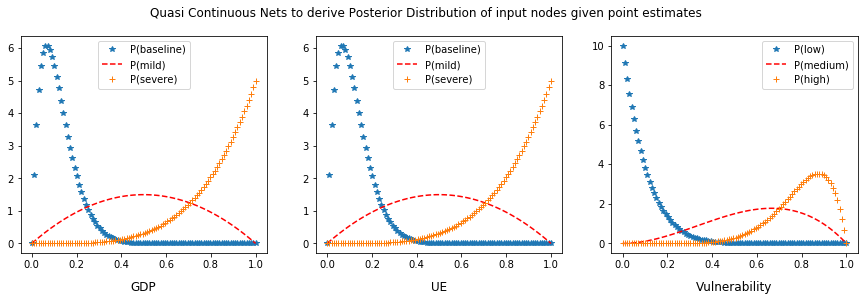

In [203]:
x = np.linspace(0, 1.0, 100) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Quasi Continuous Nets to derive Posterior Distribution of input nodes given point estimates')

# GDP
y1 = beta.pdf(x, 2, 15) 
y2 = beta.pdf(x, 2, 2) 
y3 = beta.pdf(x, 5, 1) 
ax1.plot(x, y1, "*", x, y2, "r--", x, y3, "+") 
ax1.legend(["P(baseline)","P(mild)", "P(severe)"],loc='best')
ax1.set_title('GDP', y = -0.2)

# UE
y1 = beta.pdf(x, 2, 15) 
y2 = beta.pdf(x, 2, 2) 
y3 = beta.pdf(x, 5, 1) 
ax2.plot(x, y1, "*", x, y2, "r--", x, y3, "+") 
ax2.legend(["P(baseline)","P(mild)", "P(severe)"],loc='best')
ax2.set_title('UE', y = -0.2)


# Asset & Metro Vulnerability
y1 = beta.pdf(x, 1, 10) 
y2 = beta.pdf(x, 3, 2) 
y3 = beta.pdf(x, 8, 2) 
ax3.plot(x, y1, "*", x, y2, "r--", x, y3, "+") 
ax3.legend(["P(low)","P(medium)", "P(high)"],loc='best')
ax3.set_title('Vulnerability', y = -0.2)


In [204]:
# GDP quasi continuous network
ie_gdp = makeBetaBN("real_gdp_categories", ['baseline', 'mild', 'severe'], [0.3, 0.3, 0.4],
            [{'A':2, 'B':15}, {'A':2, 'B':2}, {'A':5, 'B':1}])


#test it out

#xp_gdp = [-0.15, 0.01]
#fp = [0, 99]
#evidence = -0.12

#ie_gdp.setEvidence({'B':100 - int(round(np.interp(evidence, xp_gdp, fp)))})
#ie_gdp.makeInference()
#ie_gdp.posterior("A").tolist()



# UE  quasi continuous network
ie_ue = makeBetaBN("unemp_categories", ['baseline', 'high', 'elevated'], [0.3, 0.3, 0.4],
            [{'A':2, 'B':15}, {'A':2, 'B':2}, {'A':5, 'B':1}])


#test it out

#xp_ue = [0.0, 0.20]
#fp = [0, 99]
#evidence = 0.12

#ie_ue.setEvidence({'B':int(round(np.interp(evidence, xp_ue, fp)))})
#ie_ue.makeInference()
#ie_ue.posterior("A").tolist()

# Vulnerability  quasi continuous network
ie_vul = makeBetaBN("vul_categories", ['low', 'medium', 'high'], [0.3, 0.3, 0.4],
            [{'A':2, 'B':5}, {'A':2, 'B':2}, {'A':5, 'B':2}])


#xp_vul = [1, 10]
#fp = [0, 99]
#evidence = 2

#ie_vul.setEvidence({'B':int(round(np.interp(evidence, xp_vul, fp)))})
#ie_vul.makeInference()
#ie_vul.posterior("A").tolist()


In [205]:
import operator


def dotproduct(vec1, vec2):
    return sum(map(operator.mul, vec1, vec2))

In [206]:
# common range for beta values dist
fp = [0, 99]

# macro variables ranges
xp_gdp = [-0.50, 0.25]
xp_ue = [0.0, 0.20]
xp_vul = [0, 11]

In [207]:
def generatePosValueDist(property, gdp, ue):
    p = pm_cim.loc [ pm_cim [ 'Property Name' ] == property ]
    
    print(p.iloc[0,:])
    
    ie_gdp.setEvidence({'B':100 - int(round(np.interp(gdp, xp_gdp, fp)))})
    ie_gdp.makeInference()
    
    ie_ue.setEvidence({'B':int(round(np.interp(ue, xp_ue, fp)))})
    ie_ue.makeInference()
    
     #determine asset vulnerability posterior
    ie_vul.setEvidence({'B':int(round(np.interp(p.iloc[0]['Asset Risk Index'], xp_vul, fp)))})
    ie_vul.makeInference()
    ai = ie_vul.posterior("A").tolist()
    
    #determine metro vulnerability posterior
    ie_vul.setEvidence({'B':int(round(np.interp(p.iloc[0]['Metro Risk Index'], xp_vul, fp)))})
    ie_vul.makeInference()
    mi = ie_vul.posterior("A").tolist()

    gnb.showInference(bn, evs={"real_gdp_growth": ie_gdp.posterior("A").tolist(), "unemp_rate": ie_ue.posterior("A").tolist(), 
                                 "stabilization": p.iloc[0]['Stabilization'], 
                                 "asset_vulnerability" :ai, 
                                 "metro_knowledge_economy": p.iloc[0]['Knowledge Economy'], 
                                 "metro_vulnerability_index": mi 
                                }, size="20")

Property Name                                          30 Hudson Yards
Property Type                                                   Office
MSA                  New York-Northern New Jersey-Long Island, NY-N...
Address                                                30 Hudson Yards
City                                                          New York
State                                                               NY
Stabilization                                               stabilized
Risk Rating                                                 Performing
Knowledge Economy                                                  yes
Metro Risk Index                                                    10
Asset Risk Index                                                     1
MV Assets                                                   2201708000
MV Liabilities                                              1400000000
ASRS NAV                                                     390695411
Name: 

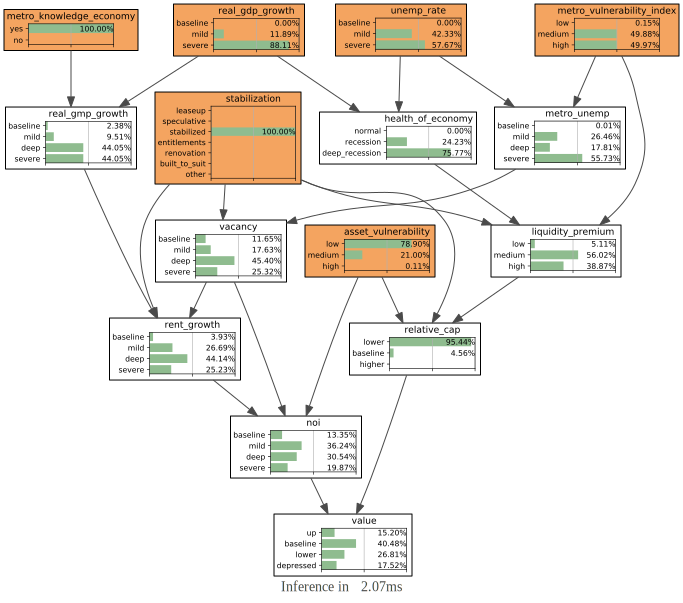

In [208]:
generatePosValueDist('Property A', -0.45, 0.16)

In [135]:
def stressed_nav(a, l, nav, d):
     if ((a <= 0) or (a-l <= 0)) :
         return nav*(1+d)
     else:
         return min(1, (nav/(a-l)*(a*(1+)))